This analysys involves testing if a training dataset with 8 different liquids could generate a good Random Forest model.
In this case we are NOT including the name of the liquid but we are including voltage, flow_rate, unidimensional voltage and unidimensional flow rate to the dataset. 
As the Random Forest model was one of the best performers, we are now going to try to do a cross validation with its parameters in order to see if we can have an even better model

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
df = pd.read_feather('../data/EW55_EW82_EW8515_EWG172_EWG343_EWP334_EWP361_EWP541_relabeled.feather')
df.head()

OSError: [Errno 22] Invalid argument: '../data/EW55_EW82_EW8515_EWG172_EWG343_EWP334_EWP361_EWP541_relabeled.feather'

In [ ]:
df = df.drop(['name', 'index'], axis='columns')
df["mean/median"] = df["mean"]/df["median"]
df["std_dev/median"] = df["deviation"]/df["median"]
df.head()

,mean,variance,deviation,median,rms,spray_mode,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,0.767964,13.973825,3.738158,0.756525,3.816228,Undefined,3000.40,1.0,6.378865e-11,2.440908,1.015120,4.941222
1,0.939377,13.891714,3.727159,1.008700,3.843715,Undefined,3000.40,1.0,6.378865e-11,2.440908,0.931275,3.695012
2,0.933078,14.675615,3.830877,1.008700,3.942873,Undefined,3000.40,1.0,6.378865e-11,2.440908,0.925030,3.797835
3,1.222892,14.586572,3.819237,1.260875,4.010242,Undefined,3000.40,1.0,6.378865e-11,2.440908,0.969876,3.029037
4,0.430110,14.113415,3.756783,0.504350,3.781324,Dripping,3200.44,1.0,6.378865e-11,2.777234,0.852800,7.448761


In [ ]:
# Checking if there are any infinite values 
print(len(df.loc[((df['mean/median'] == np.inf) | (df['std_dev/median'] == np.inf))]))

3223


In [ ]:
# Checking the proportion of infinite values / total values
print(len(df))

102643


In [ ]:
# Due to the previous analysis, it is alright to say that we can just remove the lines with inf value
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
len(df)

99420

In [ ]:
X = df.drop(['spray_mode'], axis="columns")
y = df['spray_mode']
y.unique()

array(['Undefined', 'Dripping', 'Cone Jet', 'Intermittent', 'Multi Jet',
       'Corona'], dtype=object)

In [ ]:
X.head()

,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,0.767964,13.973825,3.738158,0.756525,3.816228,3000.40,1.0,6.378865e-11,2.440908,1.015120,4.941222
1,0.939377,13.891714,3.727159,1.008700,3.843715,3000.40,1.0,6.378865e-11,2.440908,0.931275,3.695012
2,0.933078,14.675615,3.830877,1.008700,3.942873,3000.40,1.0,6.378865e-11,2.440908,0.925030,3.797835
3,1.222892,14.586572,3.819237,1.260875,4.010242,3000.40,1.0,6.378865e-11,2.440908,0.969876,3.029037
4,0.430110,14.113415,3.756783,0.504350,3.781324,3200.44,1.0,6.378865e-11,2.777234,0.852800,7.448761


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print(y_train.unique())
print(y_test.unique())
model = RandomForestClassifier(random_state=0, n_jobs=-1, max_features=3, oob_score=True)

['Intermittent' 'Dripping' 'Undefined' 'Multi Jet' 'Cone Jet' 'Corona']
['Multi Jet' 'Dripping' 'Cone Jet' 'Intermittent' 'Undefined' 'Corona']


In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(max_features=3, n_jobs=-1, oob_score=True,
                       random_state=0)

In [ ]:
model.oob_score_

0.978159036698566

In [ ]:
model.score(X_test, y_test)

0.978642794876953

['Multi Jet' 'Dripping' 'Cone Jet' 'Intermittent' 'Undefined' 'Corona']


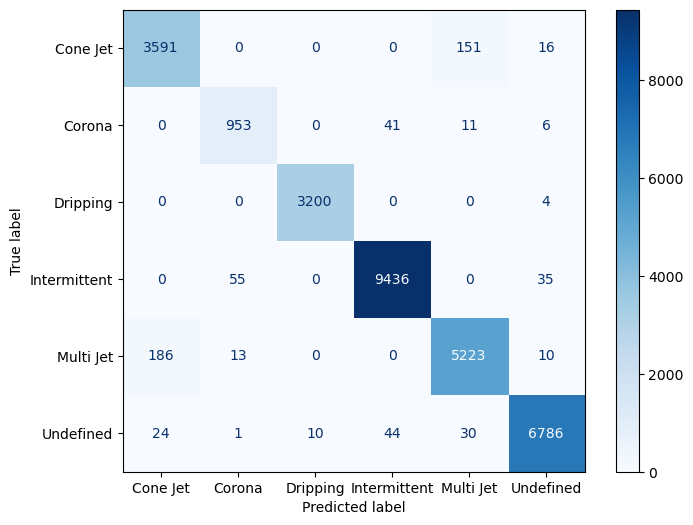

In [ ]:
import matplotlib.pyplot as plt

predicted_labels = model.predict(X_test)
true_labels = y_test

print(y_test.unique())

label_names = ['Cone Jet', 'Corona', 'Dripping', 'Intermittent', 'Multi Jet', 'Undefined']
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [ ]:
feature_names = X.columns
feature_importances = model.feature_importances_

feature_importances_dict = dict(zip(feature_names, feature_importances))
feature_importances_dict

{'mean': 0.11085325401062904,
 'variance': 0.06326532211830664,
 'deviation': 0.04993191078348284,
 'median': 0.09682499961136098,
 'rms': 0.06032578944659182,
 'voltage': 0.07951154290191824,
 'flow_rate': 0.03421952587011799,
 'Undimensional_flowrate': 0.00023760878878308263,
 'Undimensional_voltage': 0.08359216366469051,
 'mean/median': 0.23884063950554152,
 'std_dev/median': 0.18239724329857743}

Now, the cross validation

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [50],
#     'max_depth': [40, 50],
#     'max_features': [8, 10],
#     'criterion' :['gini', 'entropy']
# }

# optimal_params = GridSearchCV(estimator=RandomForestClassifier(random_state=0, n_jobs=-1, oob_score=True),
#     param_grid=param_grid,
#     n_jobs=-1,
# )

# optimal_params.fit(X_train, y_train)

# print(optimal_params.best_params_)

In [ ]:
model = RandomForestClassifier(random_state=0, n_jobs=-1, oob_score=True, n_estimators=50, max_depth=40, max_features=8, criterion='entropy')

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=40, max_features=8,
                       n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=0)

In [ ]:
model.oob_score_

0.9820099433859241

In [ ]:
model.score(X_test, y_test)

0.9819620465365788

Now, using the model obtained, we are going to predict the values of the spray_mode of a dataset without classification

In [ ]:
df = pd.read_feather('../data/EW64_testing.feather')
df = df.drop(['index'], axis='columns')
df.head()

,name,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage
0,setup/liquid/EW64,1.223271,12.602918,3.550059,1.260875,3.754905,3000.38,1.0,4.015050e-11,2.195690
1,setup/liquid/EW64,0.986307,12.542054,3.541476,1.008700,3.676256,3000.38,1.0,4.015050e-11,2.195690
2,setup/liquid/EW64,0.873368,12.659608,3.558034,0.756525,3.663656,3000.38,1.0,4.015050e-11,2.195690
3,setup/liquid/EW64,1.310569,12.849416,3.584608,1.260875,3.816675,3000.38,1.0,4.015050e-11,2.195690
4,setup/liquid/EW64,0.965084,13.203416,3.633651,1.008700,3.759628,3200.39,1.0,4.015050e-11,2.498184


In [ ]:
df = df.drop(['name'], axis='columns')
df["mean/median"] = df["mean"]/df["median"]
df["std_dev/median"] = df["deviation"]/df["median"]
df.head()

,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,1.223271,12.602918,3.550059,1.260875,3.754905,3000.38,1.0,4.015050e-11,2.195690,0.970176,2.815552
1,0.986307,12.542054,3.541476,1.008700,3.676256,3000.38,1.0,4.015050e-11,2.195690,0.977800,3.510931
2,0.873368,12.659608,3.558034,0.756525,3.663656,3000.38,1.0,4.015050e-11,2.195690,1.154447,4.703128
3,1.310569,12.849416,3.584608,1.260875,3.816675,3000.38,1.0,4.015050e-11,2.195690,1.039412,2.842953
4,0.965084,13.203416,3.633651,1.008700,3.759628,3200.39,1.0,4.015050e-11,2.498184,0.956760,3.602310


In [ ]:
len(df.loc[(df['mean/median'] == np.inf) | (df['std_dev/median'] == np.inf)])

149

In [ ]:
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(inplace=True)
# df.head()

,mean,variance,deviation,median,rms,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,1.223271,12.602918,3.550059,1.260875,3.754905,3000.38,1.0,4.015050e-11,2.195690,0.970176,2.815552
1,0.986307,12.542054,3.541476,1.008700,3.676256,3000.38,1.0,4.015050e-11,2.195690,0.977800,3.510931
2,0.873368,12.659608,3.558034,0.756525,3.663656,3000.38,1.0,4.015050e-11,2.195690,1.154447,4.703128
3,1.310569,12.849416,3.584608,1.260875,3.816675,3000.38,1.0,4.015050e-11,2.195690,1.039412,2.842953
4,0.965084,13.203416,3.633651,1.008700,3.759628,3200.39,1.0,4.015050e-11,2.498184,0.956760,3.602310


In [ ]:
predicted_labels = model.predict(df)
len(predicted_labels)

15392

In [ ]:
# Importing and treating the true values of the label to compare

df = pd.read_feather("../data/EW64_relabeled.feather")
df = df.drop(['name'], axis='columns')
df["mean/median"] = df["mean"]/df["median"]
df["std_dev/median"] = df["deviation"]/df["median"]
# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# df.dropna(inplace=True)
true_values = df['spray_mode']
len(true_values)

15392

In [26]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(predicted_labels, true_values)
accuracy

0.8668139293139293

Now we are going to plot the mode classification map based on the prediction we have made

In [27]:
df['spray_mode'] = predicted_labels
df = df.drop(['index'], axis='columns')
df.head()

,mean,variance,deviation,median,rms,spray_mode,voltage,flow_rate,Undimensional_flowrate,Undimensional_voltage,mean/median,std_dev/median
0,1.223271,12.602918,3.550059,1.260875,3.754905,Undefined,3000.38,1.0,4.015050e-11,2.195690,0.970176,2.815552
1,0.986307,12.542054,3.541476,1.008700,3.676256,Undefined,3000.38,1.0,4.015050e-11,2.195690,0.977800,3.510931
2,0.873368,12.659608,3.558034,0.756525,3.663656,Dripping,3000.38,1.0,4.015050e-11,2.195690,1.154447,4.703128
3,1.310569,12.849416,3.584608,1.260875,3.816675,Undefined,3000.38,1.0,4.015050e-11,2.195690,1.039412,2.842953
4,0.965084,13.203416,3.633651,1.008700,3.759628,Undefined,3200.39,1.0,4.015050e-11,2.498184,0.956760,3.602310


In [28]:
import seaborn as sns
sns.set(color_codes=True)
from matplotlib.lines import Line2D

def plot_mapping(df):

    colormap = []
    for electro_class in df['spray_mode']:
        if electro_class == 'Intermittent':
            colormap.append('red')
        elif electro_class == 'Cone Jet':
            colormap.append('orange')
        elif electro_class == 'Dripping':
            colormap.append('blue')
        elif electro_class == 'Multi Jet':
            colormap.append('purple')
        elif electro_class == 'Undefined':
            colormap.append('green')
        elif electro_class == 'Corona':
            colormap.append('pink')    
        else:
            colormap.append('orange')


    df.insert(1, 'colormap', colormap)
    df.info()

    #Scatterplot

    inverse_voltage = df['voltage']

    # Define a palette com as cores
    custom_palette = {'blue': 'steelblue', 'orange': 'orange', 'red': 'firebrick', 'green': 'green', 'purple': 'rebeccapurple', 'pink': 'hotpink'}

    # Plotagem
    fig, ax = plt.subplots(figsize=(20, 9))
    fig.patch.set_facecolor('white')  # Define a cor de fundo da figura como branco

    scatterplot = sns.scatterplot(data=df, x='Undimensional_flowrate', y='Undimensional_voltage', hue='colormap', palette=custom_palette, ax=ax, alpha=0.7, s=100)
    ax.set_xscale("log")
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_yticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
    Xtick = df.Undimensional_flowrate[0] #Defining the xticks
    ax.set_xticks([Xtick,(Xtick*2),(Xtick*5),(Xtick*10),(Xtick*20),(Xtick*50),(Xtick*100),(Xtick*200),(Xtick*500)])
    ax.set_ylabel('γ1', fontsize=22, labelpad=1)
    ax.set_xlabel('Q / Q0', fontsize=22,labelpad=15)

    # Increase font size for ticks and tick labels on primary axes
    ax.tick_params(axis='both', which='major', labelsize=20)

    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Dripping', markerfacecolor='cadetblue', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Intermittent', markerfacecolor='firebrick', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Multi Jet', markerfacecolor='rebeccapurple', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Cone Jet', markerfacecolor='orange', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='Undefined', markerfacecolor='green', markersize=10)]

    plt.title("Mapping Jet Modes -  EW82", fontsize=20, pad=40)
    legend = ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize=22)  # Adjust font size here


    plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 15392 entries, 0 to 15540
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   mean                    15392 non-null  float64
 1   colormap                15392 non-null  object 
 2   variance                15392 non-null  float64
 3   deviation               15392 non-null  float64
 4   median                  15392 non-null  float64
 5   rms                     15392 non-null  float64
 6   spray_mode              15392 non-null  object 
 7   voltage                 15392 non-null  float64
 8   flow_rate               15392 non-null  float64
 9   Undimensional_flowrate  15392 non-null  float64
 10  Undimensional_voltage   15392 non-null  float64
 11  mean/median             15392 non-null  float64
 12  std_dev/median          15392 non-null  float64
dtypes: float64(11), object(2)
memory usage: 1.6+ MB


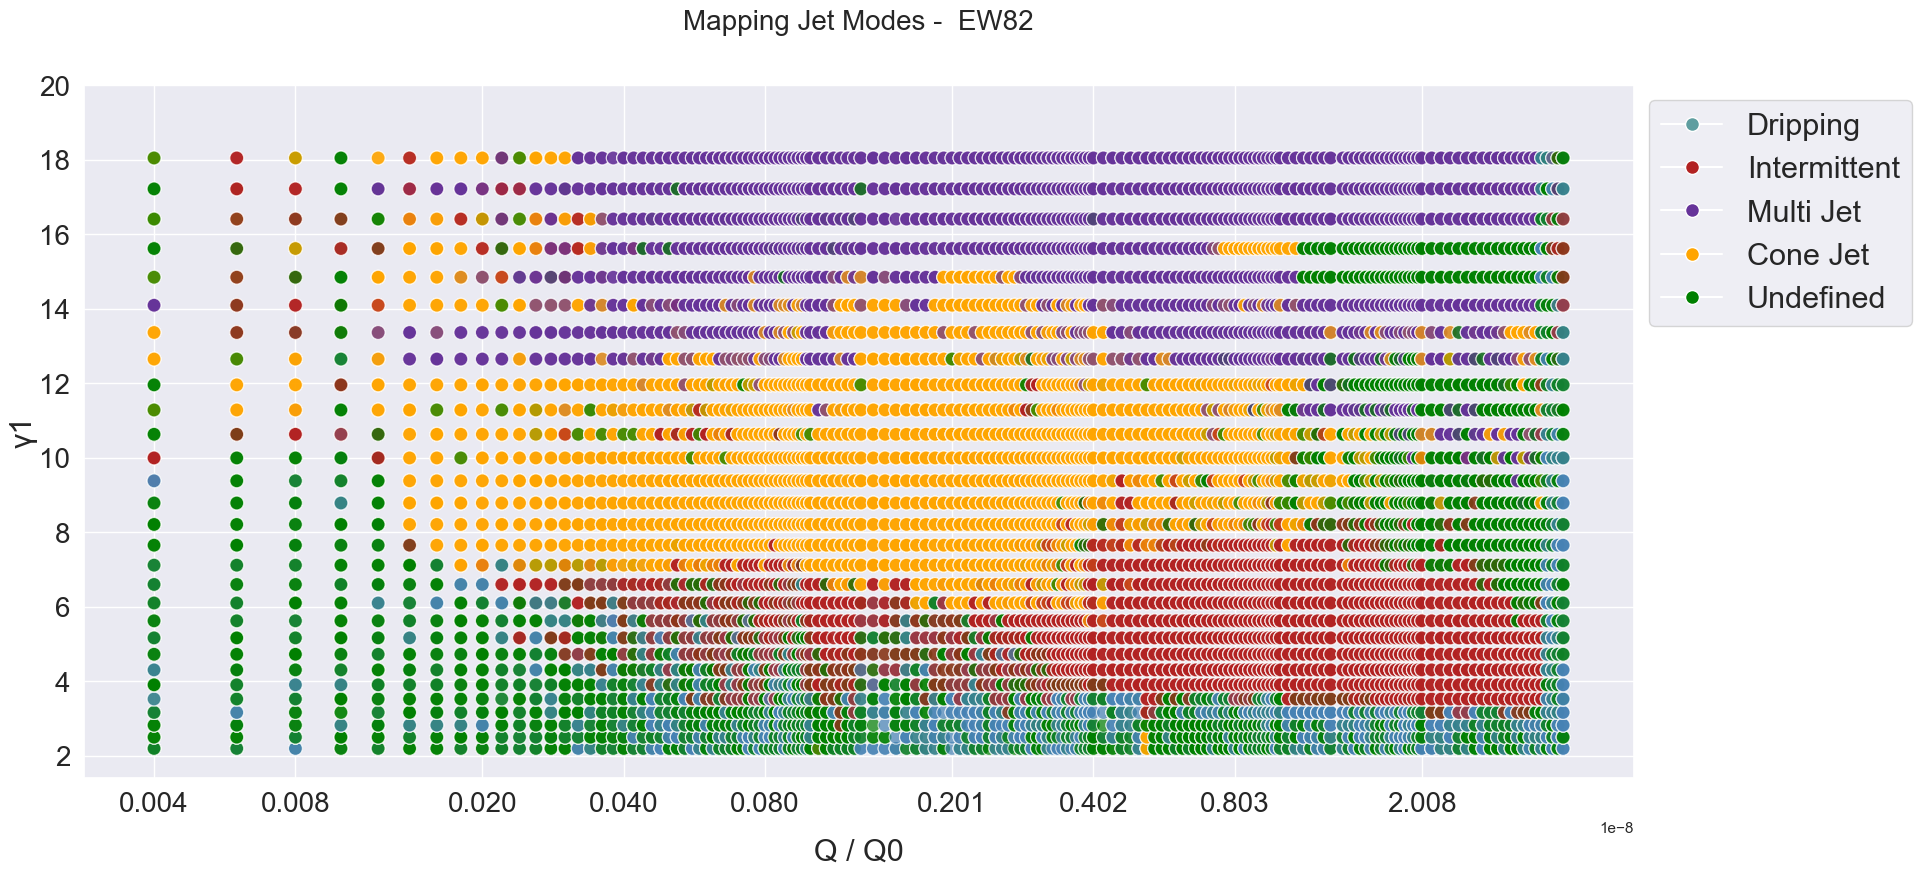

In [29]:
plot_mapping(df)

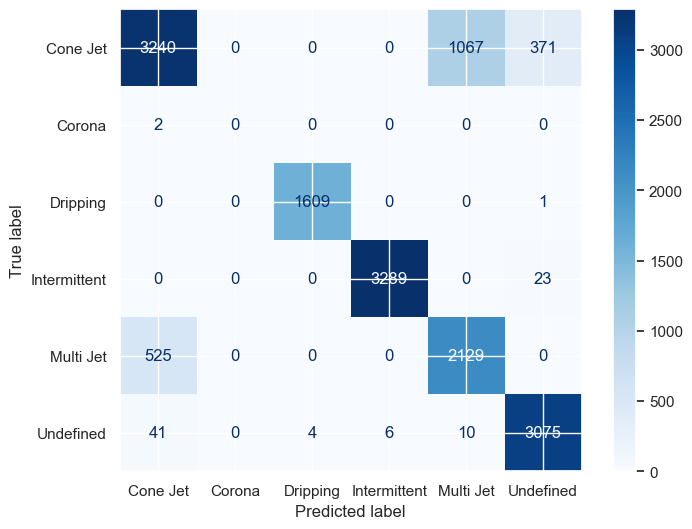

In [31]:
label_names = ['Cone Jet', 'Corona', 'Dripping', 'Intermittent', 'Multi Jet', 'Undefined']
cm = confusion_matrix(true_values, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.show()

In [32]:
import itertools

def plot_normalized_confusion_matrix(y_true, y_pred, classes, title='Normalized Confusion Matrix', cmap=plt.cm.Blues):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_normalized[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()  

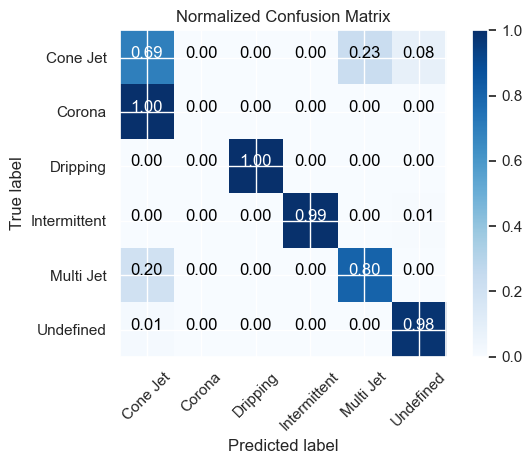

In [33]:
plot_normalized_confusion_matrix(true_values, predicted_labels, label_names)
plt.show()